In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Intialization Values
 - Grid size
 - Goal
 - Starting Point
 - obstacles 


In [2]:
size = (8, 8)        # 8 rows 8 columns

# goal has to be within the grid
goal = (5, 6)        # goal state

init = (1, 1)         # initial state

# Obstacles

#obstacles = []

obstacles = np.array([[3, 3], [2, 3], [4, 3], [6, 3], [7, 3], [5, 3],
                      [1, 6], [1, 5], [2, 5], [3, 5], [4, 5],
                      [5, 5]])

obstacles = np.array([(2, 2), (3, 1), (1, 4), (3, 3), (2, 5), (6, 4),
                      (5, 5), (6, 3), (6, 2), (5, 2)])

### Q-Learning

### Improved Q-Learning
 - Discount factor $\gamma$

In [3]:
def manhattan_distance(x, y):
    return np.abs(x[0] - y[0]) + np.abs(x[1] - y[1])

In [4]:
def get_neighbors(state, size, obstacles):
    neighbors = []
    if state[0] > 0:
        neighbors.append((state[0] - 1, state[1]))
    if state[0] < size[0] - 1:
        neighbors.append((state[0] + 1, state[1]))
    if state[1] > 0:
        neighbors.append((state[0], state[1] - 1))
    if state[1] < size[1] - 1:
        neighbors.append((state[0], state[1] + 1))


    if len(obstacles) == 0:
        return neighbors
    
    # if the neighbor is an obstacle, remove it from the list
    neighbors_copy = neighbors.copy()
    for neighbor in neighbors_copy:
        if (obstacles == neighbor).all(axis=1).any():
            neighbors.remove(neighbor)
            
    return neighbors

In [5]:
def check_complete(l, obstacles):
    flag = True
    for i in range(l.shape[0]):
        for j in range(l.shape[1]):
            if len(obstacles) != 0:
                if (obstacles == np.array([i, j])).all(axis=1).any():
                    continue
            if l[i, j] == 0:
                flag = False
                return flag

    return flag


In [6]:
# matrix containing L and Q values for each state
l = np.full(size, False)
q = np.zeros(size)

l[goal] = 1    # Lock variable matrix
q [goal] = 100  # Reward matrix
  
discount_factor = 0.8       # Discount factor

print("Initial state: ", init)
print ("goal state: ", goal)
states = []
states.append(goal)
p = states[0]


counter = 0
while (True):
    counter += 1
    d_pg = manhattan_distance(p, goal)
    neighbours = get_neighbors(p, size, obstacles)

    for n in neighbours:
        d_ng = manhattan_distance(n, goal)

        if (d_ng < d_pg):
            if l[n]:
                q[p] = discount_factor * q[n]
                l[p] = True
            elif l[p]:
                q[n] = q[p] / discount_factor
                l[n] = True
        elif (d_ng > d_pg):
            if l[p]:
                q[n] = discount_factor * q[p]
                l[n] = True
            elif l[n]:
                q[p] = q[n] / discount_factor
                l[p] = True 

    """
    For now, we will randomly select next neighbour.
    This is sufficient for the algorithm validation.
    However, some other more sophisticated methods can be used to 
    select the next neighbour to improve the performance. 
    """
    rand = np.random.randint(0, len(neighbours))
    p = neighbours[rand]
    
    if check_complete(l, obstacles):
        break
    if counter > 2000:
        break

# save Q matrix to a csv file for later analysis
np.savetxt("q.csv", q, delimiter=",")
q_df = pd.DataFrame(q).round(2)
print("Q matrix: ")
print(q_df)

Initial state:  (1, 1)
goal state:  (5, 6)
Q matrix: 
       0      1      2      3      4      5       6      7
0   8.59  10.74  13.42  16.78  20.97  26.21   32.77  26.21
1  10.74  13.42  16.78  20.97   0.00  32.77   40.96  32.77
2  13.42  16.78   0.00  26.21  32.77   0.00   51.20  40.96
3  16.78   0.00  26.21   0.00  40.96  51.20   64.00  51.20
4  20.97  26.21  32.77  40.96  51.20  64.00   80.00  64.00
5  26.21  32.77   0.00  51.20  64.00   0.00  100.00  80.00
6  20.97  26.21   0.00   0.00   0.00  64.00   80.00  64.00
7  16.78  20.97  26.21  32.77  40.96  51.20   64.00  51.20


### Visualize Q table 

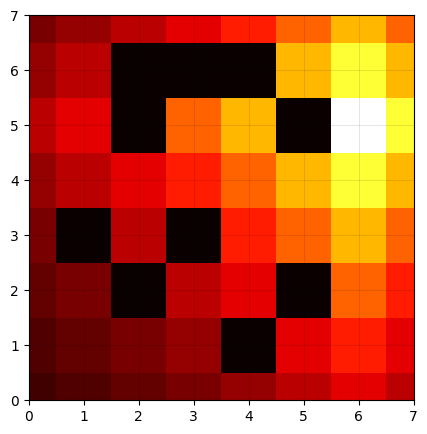

In [7]:
fig = plt.figure(figsize=(5, 5))
plt.imshow(q, cmap="hot", interpolation='nearest')
plt.xlim(0, size[1] - 1)
plt.ylim(0, size[0] - 1)
plt.xticks(np.arange(0, size[1], 1))
plt.yticks(np.arange(0, size[0], 1))
plt.grid(which='major', axis='both', linestyle='-', color='k', alpha=0.1)
plt.savefig("q.png")

### Path Planning

In [8]:
path = []

c = init
path.append(c)
while c != goal:
    neighbours = get_neighbors(c, size, obstacles)

    best_n = neighbours[0]
    best_q = q[best_n]
    for n in neighbours:
        if q[n] >= best_q:
            best_q = q[n]
            best_n = n
    c = best_n
    path.append(c)
    

### Plot

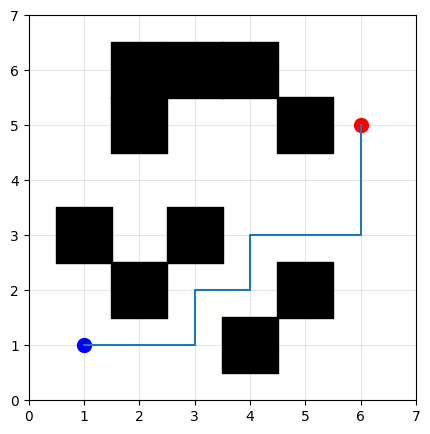

In [9]:
fig = plt.figure(figsize=(5, 5))

plt.plot(np.array(path)[:, 1], np.array(path)[:, 0])
plt.scatter(goal[1], goal[0], c='r', s=100)
plt.scatter(init[1], init[0], c='b', s=100)
if len(obstacles) != 0:
    plt.scatter(obstacles[:, 1], obstacles[:, 0], c='k', marker='s', s=1600)
plt.xlim(0, size[1] - 1)
plt.ylim(0, size[0] - 1)
plt.xticks(np.arange(0, size[1], 1))
plt.yticks(np.arange(0, size[0], 1))
plt.grid(which='major', axis='both', linestyle='-', color='k', alpha=0.1)
#plt.tick_params(which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
plt.savefig("path.png")
